## The Rossler Attractor

In [1]:
using Plots
using LinearAlgebra

In [85]:
#velocity function for the Rossler flow
function rossler_velocity(ssp, a, b, c)
    x = ssp[1]
    y = ssp[2]
    z = ssp[3]
    # Rossler flow equations:
    dxdt = - y - z
    dydt = x + a*y
    dzdt = b + z*(x-c)  
    
    [dxdt; dydt; dzdt]
end

# Stability matrix for the Rossler flow
#    Inputs:
#    ssp: State space vector. dx1 array: ssp = [x, y, z]
#    Outputs:
#    A: Stability matrix evaluated at ssp. dxd NumPy array
#       A[i, j] = del Velocity[i] / del ssp[j]

function rossler_StabilityMatrix(ssp, a, b, c)
    x = ssp[1]
    y = ssp[2]
    z = ssp[3]
    
    [0 -1 -1; 
     1  a  0;
     z  0  x-c]
end

#RK4 time integration
function rungekutta4(f, x₀, Δt, T) 
   
    # fix up Δt so it evenly divides time interval
    N = convert(Int64, round(T/Δt))
    #Δt = (t₁ - t₀)/N
    Δt2 = Δt/2
    Δt6 = Δt/6
    t = (0:N)*Δt

    x = zeros(N+1, length(x₀))
    x[1,:] = x₀

    for n = 1:N
        xn = x[n,:]
        tn = t[n]
        s1 = f(xn)
        s2 = f(xn + Δt2*s1)
        s3 = f(xn + Δt2*s2)
        s4 = f(xn + Δt *s3)

        x[n+1, :] =  xn + Δt6*(s1 + 2s2 + 2s3 + s4) # RK4 update formula
    end
    t,x
end

function rossler_EQ(a, b, c)
    EQ0 = (0.5 + 0.5 * sqrt(1.0 - 4.0 * a * b/ (c*c)) ) * [c; -c/a;c/a]
    EQ1 = (0.5 - 0.5 * sqrt(1.0 - 4.0 * a * b/ (c*c)) ) * [c; -c/a;c/a]
    
    EQ0, EQ1
end
@show EQ0, EQ1

(EQ0, EQ1) = ([5.69297, -28.4649, 28.4649], [0.0070262, -0.035131, 0.035131])


([5.69297, -28.4649, 28.4649], [0.0070262, -0.035131, 0.035131])

In [3]:
#Parameters:
a = 0.2
b = 0.2
c = 5.7

f(x) = rossler_velocity(x, a, b, c)
x₀ = [1.; 1.; 1.]
T = 1000.
Δt = 0.01

EQ0, EQ1 = rossler_EQ(a, b, c)
A = rossler_StabilityMatrix(EQ1, a, b, c)

# compute leading eigenvector of A at EQ1
Λ,V = eigen(A)
p = sortperm(real(Λ), rev=true) # find largest eigval
v = V[:,p[1]]


# Take the IC on unstable manifold of EQ1 (the one near origin)
ϵ = 1e-02
x₀ = real(EQ1 + ϵ*v)

3-element Array{Float64,1}:
  0.014099009431238133
 -0.03585877547725885 
  0.035172707376389896

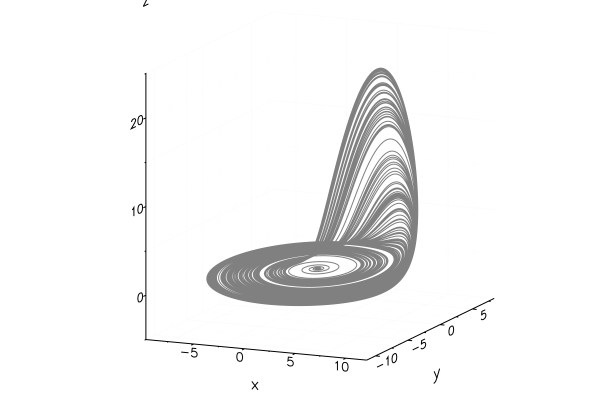

In [4]:
t,x = rungekutta4(f, x₀, Δt, T)
plot!(x[:,1], x[:,2], x[:,3], color=:grey)
plot!(legend=false, xlabel="x", ylabel="y", zlabel="z")

## Poincare section:

We start by defining a Poincare section for the Rossler attractor. For details, refer to chaosbook. 

The idea is as follows: 
* We define a Poincare section plane P by a template point $\hat{x}'$ and a normal vector $\hat{n}$.
* A point $\hat{x}$ is on this plane if U($\hat{x}$) = ($\hat{x}$ - $\hat{x}'$). $\hat{n}$ = 0

We also only want orbits/ trajectories piercing the Poncare section plane P in a specific direction. This is because, we want the first return time of the periodic orbit to be the full period of that orbit.

Therefore, we choose only those $\hat{x}$, such that v($\hat{x}$). $\hat{x}$ > 0 without loss of generality


In [5]:
# Classic Lagrange interpolation function needed for finding the intersection
# of a trajectory with the Poincare section. 

# interpolate y(x) at x = x̂, given vectors of y and x data
function interpolate(y, x, x̂)
    N = length(x)
    ŷ = zero(y[1,:])
    
    for i=1:N
        numer = 1.0;
        denom = 1.0;
        for j=1:N
            if i == j
                continue
            end
            numer *= x̂ - x[j]
            denom *= x[i] - x[j]
        end
        ŷ += y[i,:] * numer/denom
    end
    ŷ
end

interpolate (generic function with 1 method)

In [6]:
# function F integrates x(t) finds the next N intersections with the poincare section h(z) = 0
function F(f, x, Δt, N, h) 
    # find the next N intersections of h(x) = 0 poincare section 
    
    Ntmax = 1000000 # 1000000 # max # of time steps
    Δt2 = Δt/2
    Δt6 = Δt/6
   
    d = length(x)
    # storage for N Poincare intersection values
    X = zeros(N,d)

    # store x(t) and h(t) at five successive time steps
    xseq = zeros(5,d)
    hseq = zeros(5)
    count = 0
    
    for n = 1:Ntmax
        
        if n<=4  # fill in the first four values of x and h
            xseq[n+1,:] = x
            hseq[n+1] = h(x)
        end
        
        s1 = f(x)
        s2 = f(x + Δt2*s1)
        s3 = f(x + Δt2*s2)
        s4 = f(x + Δt *s3)

        x =  x + Δt6*(s1 + 2s2 + 2s3 + s4) # RK4 update formula
        
        if n>=5 
            # shift x and h sequences in time
            xseq[1:4,:] = xseq[2:5,:]
            hseq[1:4] = hseq[2:5]
            
            xseq[5,:] = x
            hseq[5] = h(x)
            
            # if h(t) changes sign, compute Poincare crossing by interpolating x as func of h at h=0
            if hseq[3] < 0 && hseq[4] >= 0
                count += 1
                X[count,:] = interpolate(xseq, hseq, 0.0)                
            end
        end
        
        if count == N
            break
        end
    end
    X
end

F (generic function with 1 method)

In [7]:
#    Rotation matrix about z-axis
#    Input:
#    theta: Rotation angle (radians)
#    Output:
#    Rz: Rotation matrix about z-axis

function zRotation(theta)
    [cos(theta) -sin(theta) 0;
     sin(theta) -cos(theta) 0;
     0          0           1]
end

#Define the Poincare section hyperplane equation
function UPoincare(ssp, sspTemplate, nTemplate)
    dot(ssp-sspTemplate, nTemplate)
end

UPoincare (generic function with 1 method)

In [8]:
# Plot the Poincare intersections along with the x(t) trajectory
#Parameters:
a = 0.2
b = 0.2
c = 5.7
f(x) = rossler_velocity(x, a, b, c)

#Set the angle between the Poincare section hyperplane and the x-axis:
thetaPoincare = -pi / 2.0

#Define vectors which will be on and orthogonal to the Poincare section hyperplane:
e_x = [1.; 0.; 0.]  # Unit vector in x-direction

#Template vector to define the Poincare section hyperplane:
sspTemplate = zRotation(thetaPoincare) * e_x#EQ1 #
@show sspTemplate

#Normal to this plane will be equal to template vector rotated pi/2 about
#the z axis:
nTemplate = zRotation(thetaPoincare + pi/2)*e_x
@show nTemplate

h(ssp) = UPoincare(ssp, sspTemplate, nTemplate);
sspSolutionPoincare = F(f, x₀, Δt, 1000, h);

plot!(x[:,1], x[:,2], x[:,3], color=:grey)
plot!(legend=false)

plot!(sspSolutionPoincare[:,1], sspSolutionPoincare[:,2], sspSolutionPoincare[:,3], marker=:circ, markersize=2, color=:blue, linecolor=nothing)

sspTemplate = [6.12323e-17, -1.0, 0.0]
nTemplate = [1.0, 0.0, 0.0]


In [9]:
#Unit vectors which will span the Poincare section hyperplane are the
#template vector and the unit vector at z. Let us construct a matrix which
#projects state space vectors onto these basis:
e_z = [0.0; 0.0; 1.0] # Unit vector in z direction

ProjPoincare = [(zRotation(thetaPoincare) * e_x) (e_z) (nTemplate)]
ProjPoincare = transpose(ProjPoincare)

@show ProjPoincare
#sspSolutionPoincare has state space vectors on its rows. We act on the
#transpose of this matrix to project each state space point onto Poincare
#basis by a simple matrix multiplication:
#Third column of this matrix should be zero if everything is correct.
PoincareSection = ProjPoincare * transpose(sspSolutionPoincare)#sspSolutionPoincare #
PoincareSection = transpose(PoincareSection)

ProjPoincare = [6.12323e-17 -1.0 0.0; 0.0 0.0 1.0; 1.0 0.0 0.0]


1000×3 Transpose{Float64,Array{Float64,2}}:
  0.0420537  0.0350819  6.12265e-17
  0.0529644  0.0350708  6.12405e-17
  0.0709415  0.0350527  6.12185e-17
  0.103267   0.0350201  6.13252e-17
  0.162493   0.0349608  6.12574e-17
  0.271551   0.0348531  6.11897e-17
  0.472662   0.0346589  6.11998e-17
  0.843672   0.0343148  6.10677e-17
  1.52799    0.033723   6.1149e-17 
  2.78829    0.0327524  6.07153e-17
  5.09232    0.0312706  6.20164e-17
  9.0436     0.029296   6.59195e-17
  6.67971    0.0304082  6.02816e-17
  ⋮                                
  7.26092    0.0301176  6.12981e-17
 10.344      0.0287531  5.9848e-17 
  3.50594    0.0322557  6.22332e-17
  6.38203    0.0305619  6.245e-17  
 10.4791     0.0286991  6.22332e-17
  3.25791    0.0324234  6.1149e-17 
  5.93922    0.0307971  6.76542e-17
 10.1358     0.0288372  5.9848e-17 
  3.93549    0.0319748  6.10406e-17
  7.13839    0.0301779  6.37511e-17
 10.4409     0.0287144  6.13387e-17
  3.3253     0.0323774  5.96311e-17

perm[N - 3:N - 1] = [51, 910, 750]
rn[k] = 6.740856365086817


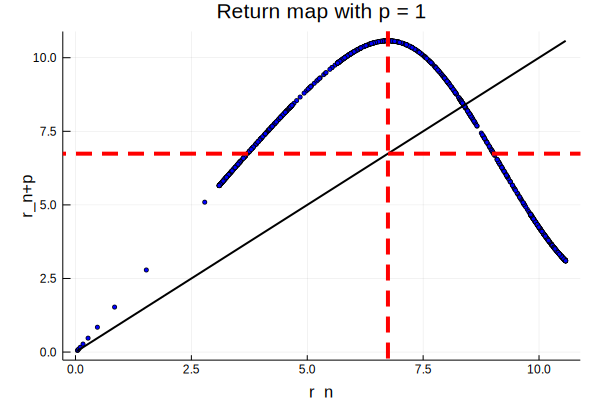

In [10]:
p = 1 # look for period-p orbit via fixed point of pth-iterate return map
N = length(PoincareSection[:, 1])

#PoincareSection intersections according to their radial distance, here, in this section that is just x

rn = PoincareSection[1:N-p, 1]
rnPlusp = PoincareSection[p+1:N, 1]

#critical point
perm = sortperm(abs.(rnPlusp[1:N-1]));
@show perm[N-3:N-1]
k = perm[N-1]
@show rn[k]


plot(rn, rnPlusp, marker=:circ, markersize=2, color=:blue, linecolor=nothing)
plot!(rn, rn, linecolor = :black, linewidth = 2)
vline!([rn[k]],color = "red", linestyle = :dash, linewidth = 4)
hline!([rn[k]],color = "red", linestyle = :dash, linewidth = 4)

plot!(xlabel="r_n", ylabel="r_n+p", legend=false)

plot!(title = "Return map with p = " * string(p))

### Find an approximate fixed point of iterated return map

In [11]:
perm = sortperm(abs.(PoincareSection[1:N-p]-PoincareSection[1+p:N]));
@show perm[1:3]
k = perm[1]

perm[1:3] = [978, 979, 980]


978

In [12]:
PoincareSection[k]

8.381012177584935

In [13]:
PoincareSection[k+p]

8.38077250954794

### Get the corresponding value of (x,y,z) from the Rossler time series data

This will serve as an initial guess for our periodic orbit search

In [14]:
xguess = sspSolutionPoincare[k,:]

3-element Array{Float64,1}:
  6.245004513516506e-17
 -8.381012177584935    
  0.029590028859602484 

In [15]:
xguess = sspSolutionPoincare[k+p,:]

3-element Array{Float64,1}:
  6.418476861114186e-17
 -8.38077250954794     
  0.02959013753171541  

In [16]:
h(sspSolutionPoincare[k,:]) #the value of sspSolutionPoincare on the Poincare section
#should be close to zero as it should lie on the section!

1.217705177797395e-18

In [17]:
@show xguess
F(f, xguess, Δt, p, h) 

xguess = [6.41848e-17, -8.38077, 0.0295901]


1×3 Array{Float64,2}:
 5.94143e-17  -8.38135  0.0295899

### Plot the approximate periodic orbit

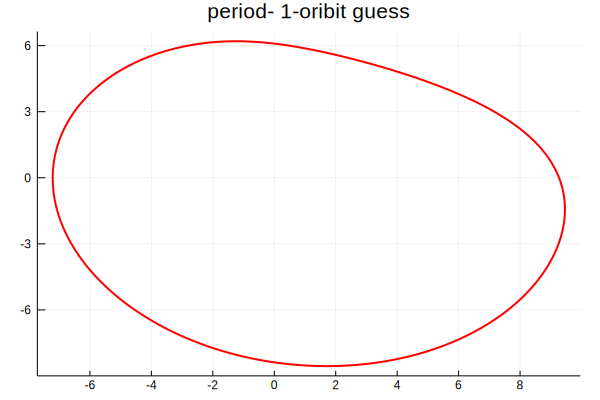

In [18]:
t,xorbguess = rungekutta4(f, xguess, Δt, 10.0);
plot(xorbguess[:,1], xorbguess[:,2], color=:red, linewidth=2)
plot!(legend = false, title = "period- "*string(p)*"-oribit guess")

### Use nonlinear solver to refine guess into periodic orbit

In [19]:
using NLsolve
xguess

3-element Array{Float64,1}:
  6.418476861114186e-17
 -8.38077250954794     
  0.02959013753171541  

In [20]:
xguessnext = F(f, xguess, Δt, p, h)

1×3 Array{Float64,2}:
 5.94143e-17  -8.38135  0.0295899

### Defining the Poincare section another way:
* The Poincare section at this point is given by $h(x) = 0$, which is, in fact $(x-\hat{x}).\hat{n} = 0$, where $x = ssp$, $\hat{x} = sspTemplate$ and $\hat{n} = nTemplate$ in the code.
<br>
We can also define the Poincare section in another way as hz(x) = function(x,y)
<br>
If we denote $\hat{n} = [a, b, c]$ and $\hat{x} = sspTemplate = [\hat{x}, \hat{y}, \hat{z}]$, 
<br>
Then $ h(x) = 0 \Rightarrow a (x-\hat{x}) + b (y - \hat{y}) + c( z - \hat{z}) = 0$
<br>
This can easily be inverted to obtain z as a function of x and y
$z = \hat{z} - \frac{a}{c} (x-\hat{x}) - \frac{b}{c} (x-\hat{x})$
<br>
Caution: this holds ONLY if $c\neq 0$

* However, we have chosen our nTemplate = [1, 0, 0], so the Poincare section is actually the y-z plane or x = 0. Hence we don't need to write a new hz function.

In [21]:
X = F(f, [0; xguess[2]; xguess[3]], Δt, p, h)
X[p,2:3]
xguess[2:3]

2-element Array{Float64,1}:
 -8.38077250954794   
  0.02959013753171541

In [22]:
# g(x) = F(x) - x, where F(x) is nth iterate of return map on Poincare section. 
# Thus roots of g(x) == 0 are periodic orbits
function g!(gx, x) 
    # compute nth iterate of Poincare map
    X = F(f, [0; x[1]; x[2]], Δt, p, h) 

    # return x,y components of F(x) -x 
    gx .= X[p,2:3] - x
end     

g! (generic function with 1 method)

In [23]:
gx = [0.0; 0.0]

g!(gx, xguess[2:3])

2-element Array{Float64,1}:
 -0.0005761421399839151
 -2.612372756033432e-7 

In [24]:
soln = nlsolve(g!, xguess[2:3])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-8.38077, 0.0295901]
 * Zero: [-8.38094, 0.0295901]
 * Inf-norm of residuals: 0.000000
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 3
 * Jacobian Calls (df/dx): 3

In [25]:
xorb₀ = vcat(0, soln.zero)

3-element Array{Float64,1}:
  0.0                
 -8.38094176940843   
  0.02959006078459083

In [26]:
h(xorb₀)

-6.123233995736766e-17

In [27]:
F(f, xorb₀, Δt, 10, h)

10×3 Array{Float64,2}:
 6.07153e-17  -8.38094  0.0295901
 6.28837e-17  -8.38094  0.0295901
 6.15827e-17  -8.38094  0.0295901
 6.15827e-17  -8.38094  0.0295901
 5.89806e-17  -8.38094  0.0295901
 5.72459e-17  -8.38094  0.0295901
 5.50775e-17  -8.38094  0.0295901
 6.1149e-17   -8.38094  0.0295901
 6.14743e-17  -8.38094  0.0295901
 5.91974e-17  -8.38094  0.0295901

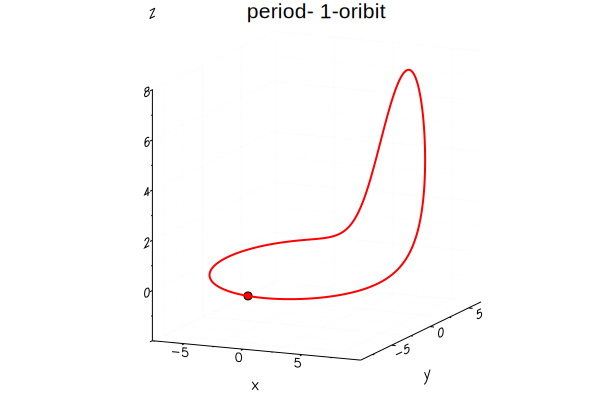

In [28]:
t, xorb = rungekutta4(f, xorb₀, Δt, 50.0)

plot([xorb₀[1]], [xorb₀[2]], [xorb₀[3]], marker=:circ, color=:red, linewidth=3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:red, linewidth=2)
plot!(legend = false, title = "period- "*string(p)*"-oribit")
plot!(xlabel="x",ylabel="y", zlabel="z")

perm[N - 3:N - 1] = [51, 910, 750]
rn[k] = 6.740856365086817


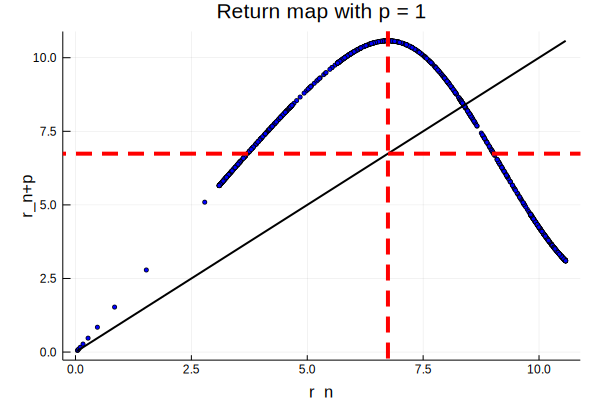

In [29]:
p = 1 # look for period-p orbit via fixed point of pth-iterate return map
N = length(PoincareSection[:, 1])

#PoincareSection intersections according to their radial distance, here, in this section that is just x

rn = PoincareSection[1:N-p, 1]
rnPlusp = PoincareSection[p+1:N, 1]

#critical point
perm = sortperm(abs.(rnPlusp[1:N-1]));
@show perm[N-3:N-1]
k = perm[N-1]
@show rn[k]


plot(rn, rnPlusp, marker=:circ, markersize=2, color=:blue, linecolor=nothing)
plot!(rn, rn, linecolor = :black, linewidth = 2)
vline!([rn[k]],color = "red", linestyle = :dash, linewidth = 4)
hline!([rn[k]],color = "red", linestyle = :dash, linewidth = 4)

plot!(xlabel="r_n", ylabel="r_n+p", legend=false)

plot!(title = "Return map with p = " * string(p))
#plot!(xlim=(8,9.5), ylim=(6,8))

## Defining Symbolic Dynamics

* I start by finding the critical point of the first return map. Since this is a no-escape map, the first partition is defined by the $r_{n}$ location of the maximum. 
* #critical point <br>
perm = sortperm(abs.(rnPlusp[1:N-1]));<br>
@show perm[N-3:N-1]<br>
k = perm[N-1]<br>
@show rn[k]<br>
gives the $r_{n}$ value of the maximum, which turned out to be $r_{n}[750] = 6.740856365086817$
* In the given temporal itinerary <br>
if $r_{n} < 6.740856365086817$, I assign it a symbol $0$ <br> 
if $r_{n} > 6.740856365086817$, I assign it a symbol $1$

* The critical point itself does not get any symbol assigned to it, but defines a partition.
* But that is not all, we can do better.
* In order to further partition the space, the pre-images of the critical point (given by the intersection of the dashed horizontal line above at $r_{n+p} = 6.740856365086817$ mark the borders of the partitions.
* For example, if I assume the red-dashed lines to be the axes of the $R^{2}$ plane and $r_{n} = r_{n+p} = 6.740856365086817$ to be the origin, a point that starts in the third quadrant remains in the third quadrant. In other words, a point that starts in $0$-partition, remains in the $0$-partition, if it belongs to this third quadrant (before the intersection point). Hence, From $r_{n} = 0$ to the intersection of the horizontal line's intersection with the return map (yet to be determined), I'll label the partition $00$. 
* Furthermore, if a point starts after intersection of the horizontal line's intersection with the return map but is before the vertical line, it lands in the partition $1$. So I will label the partition $01$. 
* Similarly, I can label the partitions $10$ and $11$. 
* To do so, I must find the intersection points of the horizontal line corresponding to the pre-image of the critical point with the first return map. 

In [30]:
radii1 = PoincareSection[1:N-1, 1]
radii2 = PoincareSection[2:N, 1]

#Indices on the order of which the radii1 is sorted from its smallest to the largest element
isort = sortperm(radii1)

radii1 = radii1[isort]  # sort radii1
radii2 = radii2[isort]  # sort radii2

999-element Array{Float64,1}:
 0.05296441155857673
 0.07094149781260155
 0.10326705739999449
 0.16249292646079855
 0.2715511761836244 
 0.4726621156132915 
 0.8436721764732719 
 1.527989213482381  
 2.7882861830392742 
 5.092315700881887  
 5.6544710944918535 
 5.654647244291265  
 5.654725744865594  
 ⋮                  
 3.106725812517709  
 3.1064906416291524 
 3.106205995194477  
 3.1052911917998025 
 3.1044546822727903 
 3.1037554719209335 
 3.1015767745297635 
 3.101334771700026  
 3.1000179889220036 
 3.099556188688842  
 3.0995125851373357 
 3.0994147419932094 

In [31]:
using Dierckx
tck = Spline1D(radii1, radii2)# Construct tck of the spline
rn = LinRange(minimum(radii1), maximum(radii1), 1000 )
rnPlus1 = evaluate(tck, rn)

1000-element Array{Float64,1}:
 0.05296441155857674
 0.07030815519862459
 0.08901654234262317
 0.10829280269919578
 0.12760408895065303
 0.14691610688043472
 0.16624989832071407
 0.1856186041591515 
 0.20501744707669262
 0.2244391796876308 
 0.24387655460625926
 0.2633223244468712 
 0.28276948337285196
 ⋮                  
 3.2931457422942527 
 3.2746187178599837 
 3.2562680009037117 
 3.2380958160735887 
 3.2201043963244143 
 3.2022959797555743 
 3.184672813774067  
 3.1672371514423716 
 3.149991250492379  
 3.1329373721812117 
 3.1160777811751323 
 3.0994147419932094 

perm[N - 3:N - 1] = [635, 637, 636]
rn[k] = 6.737145298700728


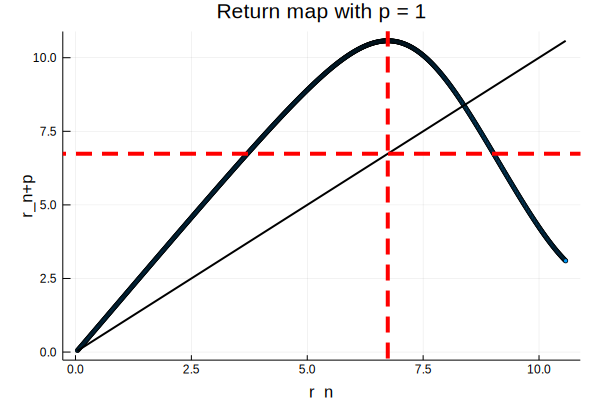

In [32]:
p = 1 # look for period-p orbit via fixed point of pth-iterate return map
N = length(rnPlus1)

#critical point
perm = sortperm(abs.(rnPlus1[1:N-1]));
@show perm[N-3:N-1]
k = perm[N-1]
@show rn[k]

partitionBoundary0 = rn[k]

plot(rn, rnPlus1, marker=:circ, markersize=2, linecolor=:blue, linewidth = 2)
plot!(rn, rn, linecolor = :black, linewidth = 2)
vline!([partitionBoundary0],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary0],color = "red", linestyle = :dash, linewidth = 4)

plot!(xlabel="r_n", ylabel="r_n+p", legend=false)

plot!(title = "Return map with p = " * string(p))
#plot!(xlim=(8,9.5), ylim=(6,8))

In [33]:
#guesses:
N = length(rnPlus1)
rnPlus1MaxLocation = rn[k]

tol = 1e-2
count = 1
candidates = []
for i= 1:N
    if(abs.(rnPlus1[i]-rnPlus1MaxLocation) <= tol)
        @show i
        candidates = vcat(candidates, rn[i])
    end
end
@show candidates

i = 349
i = 853
candidates = Any[3.71117, 9.02507]


2-element Array{Any,1}:
 3.711174770754363
 9.025074234465054

In [34]:
function refinePartition!(F1, rnguess)
           F1[1]= evaluate(tck, rnguess)[1] - MaxLocation
end

refinePartition! (generic function with 1 method)

In [35]:
using NLsolve

rnGuess1 = candidates[1]
@show rnGuess1
getPartitionBoundary = [0.0]

rnGuess1 = candidates[1]
@show rnGuess1
MaxLocation = rn[k]
@show MaxLocation
refinePartition!(getPartitionBoundary, rnGuess1)


rnGuess1 = 3.711174770754363
rnGuess1 = 3.711174770754363
MaxLocation = 6.737145298700728


0.008188819365875233

In [36]:
partitionBoundary1 = nlsolve(refinePartition!, [rnGuess1])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.71117]
 * Zero: [3.70653]
 * Inf-norm of residuals: 0.000000
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 3
 * Jacobian Calls (df/dx): 3

In [37]:
partitionBoundary1.zero

1-element Array{Float64,1}:
 3.7065284918731956

In [38]:
rnGuess2 = candidates[2]
MaxLocation = rn[k]
refinePartition!(getPartitionBoundary, rnGuess2)


-0.008242587201229945

In [39]:
partitionBoundary2 = nlsolve(refinePartition!, [rnGuess2])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [9.02507]
 * Zero: [9.02197]
 * Inf-norm of residuals: 0.000000
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 3
 * Jacobian Calls (df/dx): 3

In [40]:
partitionBoundary2.zero

1-element Array{Float64,1}:
 9.021968806752101

In [41]:
@show evaluate(tck,partitionBoundary1.zero)
@show evaluate(tck,partitionBoundary2.zero)

evaluate(tck, partitionBoundary1.zero) = [6.73715]
evaluate(tck, partitionBoundary2.zero) = [6.73715]


1-element Array{Float64,1}:
 6.737145298700729

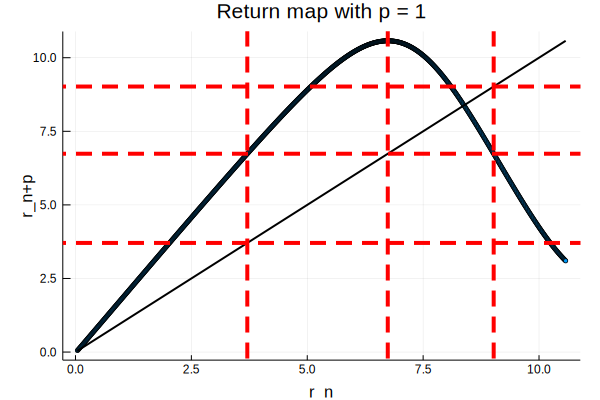

In [42]:
p = 1 # look for period-p orbit via fixed point of pth-iterate return map
N = length(rnPlus1)


plot(rn, rnPlus1, marker=:circ, markersize=2, linecolor=:blue, linewidth = 2)
plot!(rn, rn, linecolor = :black, linewidth = 2)
vline!([partitionBoundary0],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary0],color = "red", linestyle = :dash, linewidth = 4)

vline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
vline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)

plot!(xlabel="r_n", ylabel="r_n+p", legend=false)

plot!(title = "Return map with p = " * string(p))
#plot!(xlim=(8,9.5), ylim=(6,8))

### Now, let's find the period-2 orbit and symbolically label it by its itinerary

In [43]:
p = 2
N = length(PoincareSection[:, 1])
radii1 = PoincareSection[1:N-p, 1]
radii2 = PoincareSection[p+1:N, 1]
#@show radii2
#Indices on the order of which the radii1 is sorted from its smallest to the largest element
isort = sortperm(radii1)

#@show isort
radii1 = radii1[isort]  # sort radii1
radii2 = radii2[isort]  # sort radii2

using Dierckx
tck = Spline1D(radii1, radii2)# Construct tck of the spline
rn = LinRange(minimum(radii1), maximum(radii1), 1000 )
rnPlus2 = evaluate(tck, rn)

1000-element Array{Float64,1}:
 0.07094149781260155
 0.10211692743766727
 0.13629579127770103
 0.17174089311746019
 0.20728763550746582
 0.24285306571595985
 0.27847429660288237
 0.31417365066198694
 0.34993990796203234
 0.3857572246701366 
 0.42160975695341796
 0.45748166097899456
 0.493357614684589  
 ⋮                  
 6.00233617028241   
 5.969152451780175  
 5.936266229032213  
 5.903682325113985  
 5.871405558813021  
 5.839440737777818  
 5.8077926671469635 
 5.776466144078368  
 5.745465955565714  
 5.714796877469119  
 5.684463674511636  
 5.6544710944918535 

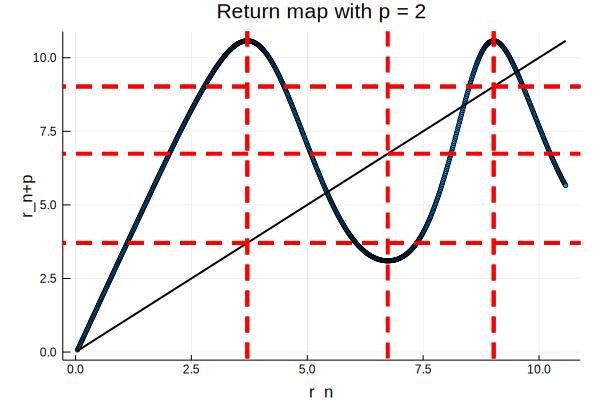

In [44]:
p = 2 # look for period-p orbit via fixed point of pth-iterate return map
N = length(rnPlus2)

#critical point

plot(rn, rnPlus2, marker=:circ, markersize=2, linecolor=:blue, linewidth = 2)
plot!(rn, rn, linecolor = :black, linewidth = 2)

vline!([partitionBoundary0],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary0],color = "red", linestyle = :dash, linewidth = 4)

vline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
vline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)


vline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
vline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)

plot!(xlabel="r_n", ylabel="r_n+p", legend=false)

plot!(title = "Return map with p = " * string(p))
#plot!(xlim=(8,9.5), ylim=(6,8))

In [45]:
@show p
perm = sortperm(abs.(rnPlus2[1:N-p]-rnPlus2[1+p:N]));
@show perm[1:10]
k = perm[1]

@show PoincareSection[k]
@show PoincareSection[k+p]

p = 2
perm[1:10] = [635, 348, 636, 634, 347, 852, 637, 633, 349, 638]
PoincareSection[k] = 10.118783855428157
PoincareSection[k + p] = 7.203093118788798


7.203093118788798

### Get the corresponding value of (x,y,z) from the Rossler time series data

This will serve as an initial guess for our periodic orbit search

In [46]:
xguess = sspSolutionPoincare[k,:]

3-element Array{Float64,1}:
   6.071532165918825e-17
 -10.118783855428157    
   0.02884413563109539  

### Plot the approximate periodic orbit

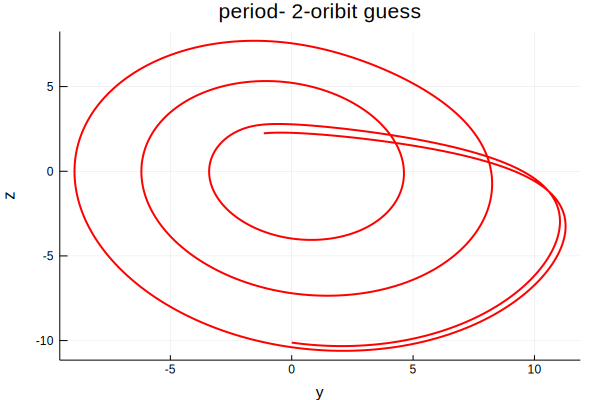

In [47]:
t,xorbguess = rungekutta4(f, xguess, Δt, 20.0);
plot(xorbguess[:,1], xorbguess[:,2], color=:red, linewidth=2)
plot!(legend = false, title = "period- "*string(p)*"-oribit guess", xlabel = "y", ylabel ="z")

### Use nonlinear solver to refine guess into periodic orbit

In [48]:
xguessnext = F(f, xguess, Δt, p, h)

@show xguess
@show xguessnext

xguess = [6.07153e-17, -10.1188, 0.0288441]
xguessnext = [6.1149e-17 -3.97269 0.031951; 6.63532e-17 -7.20309 0.030146]


2×3 Array{Float64,2}:
 6.1149e-17   -3.97269  0.031951
 6.63532e-17  -7.20309  0.030146

In [49]:
gx = [0.0; 0.0]
g!(gx, xguess[2:3])
soln = nlsolve(g!, xguess[2:3])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-10.1188, 0.0288441]
 * Zero: [-9.51986, 0.0290921]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [50]:
xorb₀ = vcat(0, soln.zero)

3-element Array{Float64,1}:
  0.0                
 -9.519860877198436  
  0.02909214476592841

In [51]:
F(f, xorb₀, Δt, 10, h)

10×3 Array{Float64,2}:
 5.76796e-17  -5.42407  0.0310812
 6.89553e-17  -9.51986  0.0290921
 6.50521e-17  -5.42407  0.0310812
 6.245e-17    -9.51986  0.0290921
 5.85469e-17  -5.42407  0.0310812
 5.89806e-17  -9.51986  0.0290921
 6.76542e-17  -5.42407  0.0310812
 6.41848e-17  -9.51986  0.0290921
 5.9848e-17   -5.42407  0.0310812
 6.50521e-17  -9.51986  0.0290921

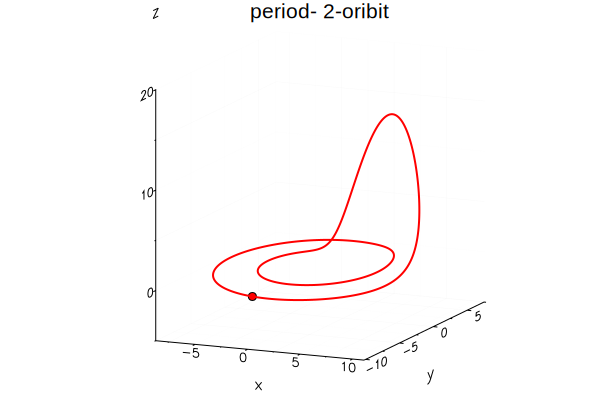

In [52]:
t, xorb = rungekutta4(f, xorb₀, Δt, 25.0)

plot([xorb₀[1]], [xorb₀[2]], [xorb₀[3]], marker=:circ, color=:red, linewidth=3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:red, linewidth=2)
plot!(legend = false, title = "period- "*string(p)*"-oribit")
plot!(xlabel="x",ylabel="y", zlabel="z")

### Writing the trajectory in terms of r

In [53]:
sspSolutionPoincare = F(f, xorb₀, Δt, 1000, h);
PoincareSection = ProjPoincare * transpose(sspSolutionPoincare[1:10,:])#sspSolutionPoincare #
PoincareSection = transpose(PoincareSection)
period_2_itiniary = PoincareSection[1:10-p, 1]

8-element Array{Float64,1}:
 5.424073886771396 
 9.51986087692078  
 5.4240738873717955
 9.519860877724687 
 5.424073885226569 
 9.519860874802275 
 5.424073892759585 
 9.519860885031317 

In [54]:
function get_symbolic_seq(period_p_itiniary, p)
    symbolic_period_p = "period-"*string(p)*"-oribit-symbolic-sequence-"

for i=1:length(period_p_itiniary)
    if(period_p_itiniary[i]< partitionBoundary0)
        symbol = "A"
        
    else
        symbol = "B"
    end
    symbolic_period_p = string(symbolic_period_p, symbol)
end

    symbolic_period_p
end

get_symbolic_seq (generic function with 1 method)

In [55]:
get_symbolic_seq(period_2_itiniary, 2)

"period-2-oribit-symbolic-sequence-ABABABAB"

### Period-3 orbit

In [56]:
p = 3

#sspSolutionPoincare has state space vectors on its rows. We act on the
#transpose of this matrix to project each state space point onto Poincare
#basis by a simple matrix multiplication:
#Third column of this matrix should be zero if everything is correct.
PoincareSection = ProjPoincare * transpose(sspSolutionPoincare)#sspSolutionPoincare #
PoincareSection = transpose(PoincareSection)

N = length(PoincareSection[:, 1])
@show N
radii1 = PoincareSection[1:N-p, 1]
radii2 = PoincareSection[p+1:N, 1]
#@show radii2
#Indices on the order of which the radii1 is sorted from its smallest to the largest element
isort = sortperm(radii1)

#@show isort
radii1 = radii1[isort]  # sort radii1
radii2 = radii2[isort]  # sort radii2

using Dierckx
tck = Spline1D(radii1, radii2)# Construct tck of the spline
rn = LinRange(minimum(radii1), maximum(radii1), 1000 )#radii1#
rnPlusp = evaluate(tck, rn)#radii2#

N = 1000


1000-element Array{Float64,1}:
  4.672815120019028
  4.632892711557947
  4.593449977693006
  4.554491541098911
  4.516021872570622
  4.478045287099582
  4.440565943171227
  4.40358783659274 
  4.367114798784328
  4.331150494003994
  4.295698411329489
  4.260761869437425
  4.226344006228295
  ⋮                
 10.093407433153272
 10.06942728755914 
 10.045178090443205
 10.020680113897793
  9.995953160821818
  9.971016568416351
  9.945889214001527
  9.920589521113333
  9.895135465941816
  9.869544582412445
  9.843833969836453
  9.818020300095169

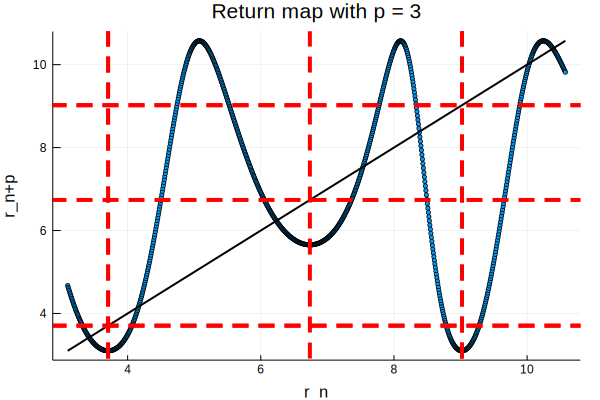

In [57]:
p = 3 # look for period-p orbit via fixed point of pth-iterate return map
N = length(rnPlusp)

#critical point

plot(rn, rnPlusp, marker=:circ, markersize=2, linecolor=:blue, linewidth = 2)
plot!(rn, rn, linecolor = :black, linewidth = 2)

vline!([partitionBoundary0],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary0],color = "red", linestyle = :dash, linewidth = 4)

vline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
vline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)


vline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
vline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)

plot!(xlabel="r_n", ylabel="r_n+p", legend=false)

plot!(title = "Return map with p = " * string(p))
#plot!(xlim=(8,9.5), ylim=(6,8))

In [58]:
@show p
perm = sortperm(abs.(rnPlus2[1:N-p]-rnPlus2[1+p:N]));
@show perm[1:10]
k = perm[1]

@show PoincareSection[k]
@show PoincareSection[k+p]

p = 3
perm[1:10] = [347, 635, 634, 851, 636, 633, 348, 346, 637, 632]
PoincareSection[k] = 9.937864083552801
PoincareSection[k + p] = 9.412127420518011


9.412127420518011

### Get the corresponding value of (x,y,z) from the time series data

This will serve as an initial guess for our periodic orbit search

In [59]:
@show xguess = sspSolutionPoincare[k,:]
@show xguessNext = sspSolutionPoincare[k+p,:]

xguess = sspSolutionPoincare[k, :] = [6.72205e-17, -9.93786, 0.0289181]
xguessNext = sspSolutionPoincare[k + p, :] = [6.10406e-17, -9.41213, 0.0291377]


3-element Array{Float64,1}:
  6.10405823109339e-17
 -9.412127420518011   
  0.029137725820083664

In [60]:
gx = [0.0; 0.0]
g!(gx, xguess[2:3])
soln = nlsolve(g!, xguess[2:3])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-9.93786, 0.0289181]
 * Zero: [-10.033, 0.0288791]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

In [61]:
xorb₀ = vcat(0, soln.zero)

3-element Array{Float64,1}:
   0.0                 
 -10.032989270855905   
   0.028879115395388153

In [62]:
F(f, xorb₀, Δt, 10, h)

10×3 Array{Float64,2}:
 5.85469e-17   -4.16474  0.0318294
 6.07153e-17   -7.53465  0.0299849
 5.81132e-17  -10.033    0.0288791
 5.87638e-17   -4.16474  0.0318294
 6.08237e-17   -7.53465  0.0299849
 5.94143e-17  -10.033    0.0288791
 6.33174e-17   -4.16474  0.0318294
 6.76542e-17   -7.53465  0.0299849
 5.46438e-17  -10.033    0.0288791
 6.33174e-17   -4.16474  0.0318294

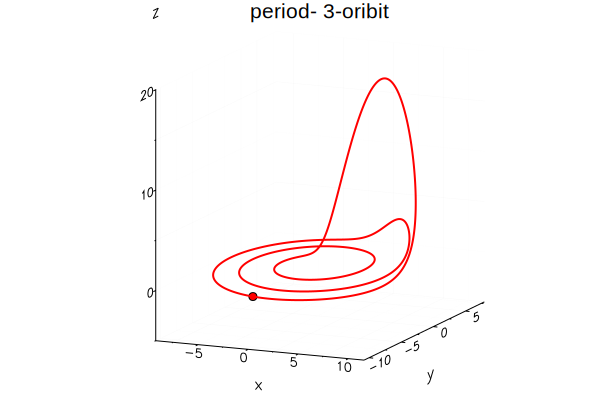

In [63]:
t, xorb = rungekutta4(f, xorb₀, Δt, 25.0)

plot([xorb₀[1]], [xorb₀[2]], [xorb₀[3]], marker=:circ, color=:red, linewidth=3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:red, linewidth=2)
plot!(legend = false, title = "period- "*string(p)*"-oribit")
plot!(xlabel="x",ylabel="y", zlabel="z")

### Writing the trajectory in terms of r

In [64]:
sspSolutionPoincare = F(f, xorb₀, Δt, 1000, h);
PoincareSec = ProjPoincare * transpose(sspSolutionPoincare)#sspSolutionPoincare #
PoincareSec = transpose(PoincareSec)
period_3_itiniary = PoincareSec[1:20, 1]

20-element Array{Float64,1}:
  4.16473603329519  
  7.534650695774565 
 10.032989270831026 
  4.16473603316287  
  7.534650695581083 
 10.032989271202307 
  4.164736032418586 
  7.534650694252312 
 10.032989272933616 
  4.164736028401892 
  7.5346506874074795
 10.032989282323417 
  4.164736007034108 
  7.534650650722709 
 10.032989332569825 
  4.164735892642482 
  7.534650454621383 
 10.03298960084243  
  4.164735281403784 
  7.534649406632563 

In [65]:
get_symbolic_seq(period_3_itiniary, p)

"period-3-oribit-symbolic-sequence-ABBABBABBABBABBABBAB"

In [66]:
k = perm[2]

@show PoincareSection[k]
@show PoincareSection[k+p]

PoincareSection[k] = 3.5963292956615613
PoincareSection[k + p] = 3.147154625442786


3.147154625442786

### Get the corresponding value of (x,y,z) from the Rossler time series data

This will serve as an initial guess for our periodic orbit search

In [67]:
@show xguess = sspSolutionPoincare[k,:]
@show xguessNext = sspSolutionPoincare[k+p,:]

xguess = sspSolutionPoincare[k, :] = [6.0878e-17, -5.70492, 0.0309249]
xguessNext = sspSolutionPoincare[k + p, :] = [5.9848e-17, -8.14483, 0.029698]


3-element Array{Float64,1}:
  5.984795992119984e-17
 -8.144825532074536    
  0.029697965618394304 

In [68]:
gx = [0.0; 0.0]
g!(gx, xguess[2:3])
soln = nlsolve(g!, xguess[2:3])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-5.70492, 0.0309249]
 * Zero: [-6.23316, 0.0306401]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

In [69]:
xorb₀ = vcat(0, soln.zero)

3-element Array{Float64,1}:
  0.0                 
 -6.2331588884684415  
  0.030640111624567666

In [70]:
F(f, xorb₀, Δt, 10, h)

10×3 Array{Float64,2}:
 4.33681e-17  -10.388    0.0287355
 5.68122e-17   -3.42232  0.0323118
 5.94143e-17   -6.23316  0.0306401
 5.68122e-17  -10.388    0.0287355
 6.1149e-17    -3.42232  0.0323118
 6.07153e-17   -6.23316  0.0306401
 6.33174e-17  -10.388    0.0287355
 6.245e-17     -3.42232  0.0323118
 6.59195e-17   -6.23316  0.0306401
 6.245e-17    -10.388    0.0287355

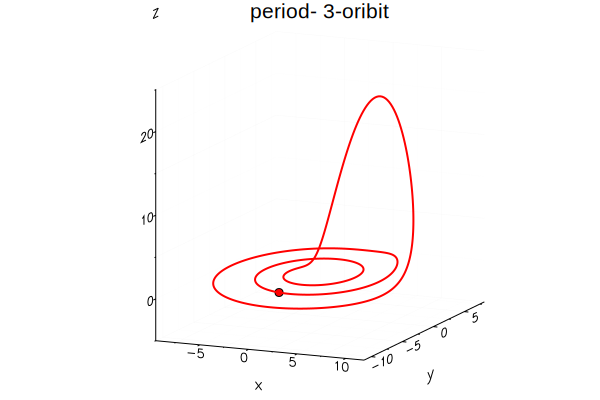

In [71]:
t, xorb = rungekutta4(f, xorb₀, Δt, 25.0)

plot([xorb₀[1]], [xorb₀[2]], [xorb₀[3]], marker=:circ, color=:red, linewidth=3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:red, linewidth=2)
plot!(legend = false, title = "period- "*string(p)*"-oribit")
plot!(xlabel="x",ylabel="y", zlabel="z")

### Writing the trajectory in terms of r

In [72]:
sspSolutionPoincare = F(f, xorb₀, Δt, 1000, h);
PoincareSec = ProjPoincare * transpose(sspSolutionPoincare[1:20,:])#sspSolutionPoincare #
PoincareSec = transpose(PoincareSec)
period_3_itiniary = PoincareSec[1:20, 1]

20-element Array{Float64,1}:
 10.387989260703186 
  3.422321533754043 
  6.233158891376246 
 10.387989262812042 
  3.422321529895622 
  6.2331588844811945
 10.387989257940228 
  3.42232153896323  
  6.233158900675179 
 10.387989269305342 
  3.4223215176813397
  6.233158862705761 
 10.387989242715255 
  3.4223215675465477
  6.233158951651866 
 10.387989305046155 
  3.4223214507439756
  6.233158743360936 
 10.387989158980455 
  3.4223217242989645

In [73]:
get_symbolic_seq(period_3_itiniary, p)

"period-3-oribit-symbolic-sequence-BAABAABAABAABAABAABA"

In [74]:
get_symbolic_seq(period_3_itiniary, 3)

"period-3-oribit-symbolic-sequence-BAABAABAABAABAABAABA"

### Period-4 orbit

In [75]:
p = 4
N = length(PoincareSection[:, 1])
radii1 = PoincareSection[1:N-p, 1]
radii2 = PoincareSection[p+1:N, 1]
#@show radii2
#Indices on the order of which the radii1 is sorted from its smallest to the largest element
isort = sortperm(radii1)

#@show isort
radii1 = radii1[isort]  # sort radii1
radii2 = radii2[isort]  # sort radii2

using Dierckx
tck = Spline1D(radii1, radii2)# Construct tck of the spline
rn = LinRange(minimum(radii1), maximum(radii1), 1000 )
rnPlusp = evaluate(tck, rn)

1000-element Array{Float64,1}:
 8.385238327766555 
 8.320162791173303 
 8.255527411510338 
 8.191366325079121 
 8.127711773670471 
 8.064594191864535 
 8.00204232688904  
 7.9400833031129405
 7.878742711241918 
 7.818044690120584 
 7.758011967952536 
 7.698665975907662 
 7.640026869588326 
 ⋮                 
 4.02876470176654  
 4.082327516231143 
 4.137036001348354 
 4.192842740907503 
 4.249699105315315 
 4.307555417097386 
 4.366361098247188 
 4.426064820904132 
 4.48661464764807  
 4.547958173028571 
 4.610042651707567 
 4.6728151200190275

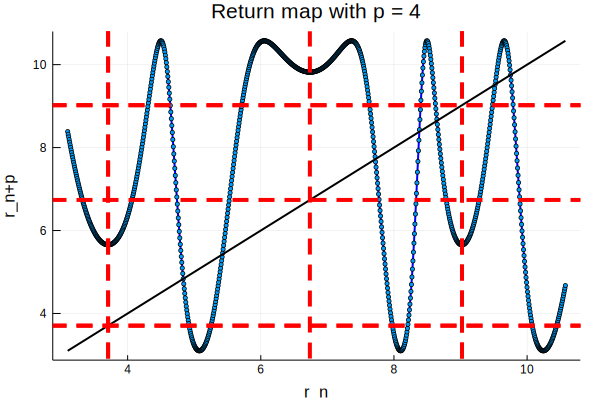

In [76]:
p = 4 # look for period-p orbit via fixed point of pth-iterate return map
N = length(rnPlusp)

#critical point

plot(rn, rnPlusp, marker=:circ, markersize=2, linecolor=:blue, linewidth = 2)
plot!(rn, rn, linecolor = :black, linewidth = 2)

vline!([partitionBoundary0],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary0],color = "red", linestyle = :dash, linewidth = 4)

vline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
vline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)


vline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary1.zero],color = "red", linestyle = :dash, linewidth = 4)
vline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)
hline!([partitionBoundary2.zero],color = "red", linestyle = :dash, linewidth = 4)

plot!(xlabel="r_n", ylabel="r_n+p", legend=false)

plot!(title = "Return map with p = " * string(p))
#plot!(xlim=(8,9.5), ylim=(6,8))

In [77]:
@show p
perm = sortperm(abs.(rnPlusp[1:N-p]-rn[1:N-p]));
@show perm[1:10]
k = perm[2]

@show PoincareSection[k]
@show PoincareSection[k+p]

p = 4
perm[1:10] = [233, 859, 890, 312, 742, 707, 311, 618, 619, 860]
PoincareSection[k] = 5.589637102122419
PoincareSection[k + p] = 7.5715909976632005


7.5715909976632005

### Get the corresponding value of (x,y,z) from the time series data

This will serve as an initial guess for our periodic orbit search

In [78]:
@show xguess = sspSolutionPoincare[k,:]
@show xguessNext = sspSolutionPoincare[k+p,:]

xguess = sspSolutionPoincare[k, :] = [6.33174e-17, -9.8212, 0.0289662]
xguessNext = sspSolutionPoincare[k + p, :] = [6.13658e-17, -8.33268, 0.029612]


3-element Array{Float64,1}:
  6.136584296267955e-17
 -8.332683514308442    
  0.029611977434709474 

In [79]:
gx = [0.0; 0.0]
g!(gx, xguess[2:3])
soln = nlsolve(g!, xguess[2:3])


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-9.8212, 0.0289662]
 * Zero: [-9.75187, 0.028995]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

In [80]:
xorb₀ = vcat(0, soln.zero)
F(f, xorb₀, Δt, 15, h)

15×3 Array{Float64,2}:
 5.9848e-17   -4.83555  0.0314208
 6.50521e-17  -8.64656  0.0294707
 6.07153e-17  -7.72001  0.0298965
 6.15827e-17  -9.75187  0.028995 
 6.28837e-17  -4.83555  0.0314208
 6.41848e-17  -8.64656  0.0294707
 6.07153e-17  -7.72001  0.0298965
 6.15827e-17  -9.75187  0.028995 
 6.13658e-17  -4.83555  0.0314208
 7.02563e-17  -8.64656  0.0294707
 6.07153e-17  -7.72001  0.0298965
 6.41848e-17  -9.75187  0.028995 
 6.23416e-17  -4.83555  0.0314208
 6.76542e-17  -8.64656  0.0294707
 5.89806e-17  -7.72001  0.0298965

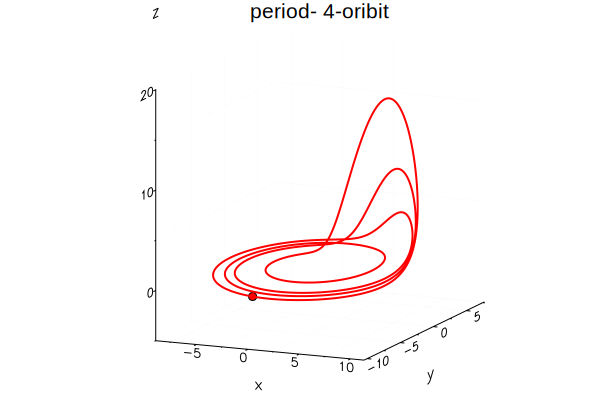

In [81]:
t, xorb = rungekutta4(f, xorb₀, Δt, 25.0)

plot([xorb₀[1]], [xorb₀[2]], [xorb₀[3]], marker=:circ, color=:red, linewidth=3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:red, linewidth=2)
plot!(legend = false, title = "period- "*string(p)*"-oribit")
plot!(xlabel="x",ylabel="y", zlabel="z")

### Writing the trajectory in terms of r

In [82]:
sspSolutionPoincare = F(f, xorb₀, Δt, 20, h);
PoincareSec = ProjPoincare * transpose(sspSolutionPoincare)#sspSolutionPoincare #
PoincareSec = transpose(PoincareSec)
period_4_itiniary = PoincareSec[1:20, 1]

20-element Array{Float64,1}:
 4.835547640122331 
 8.646561983434072 
 7.720013532668347 
 9.751874567050649 
 4.835547640019605 
 8.64656198325596  
 7.720013533096123 
 9.751874566307858 
 4.835547641806798 
 8.646561986077444 
 7.720013525892642 
 9.751874578267925 
 4.8355476121397825
 8.646561939051695 
 7.720013646305345 
 9.751874378419476 
 4.835548107711721 
 8.646562724503509 
 7.7200116360983   
 9.751877715343005 

In [83]:
get_symbolic_seq(period_4_itiniary, p)

"period-4-oribit-symbolic-sequence-ABBBABBBABBBABBBABBB"